<a href="https://colab.research.google.com/github/BannedMatt/SSL26/blob/main/TP_CLIP_matthew_banawa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : apprentissage multimodal


Dans ce TP, nous allons utiliser le modèle d'apprentissage, FashionCLIP, pré-entraîné sur des images ainsi que des descriptions en langage naturel. Plus particulièrement, nous allons considérer deux cas d'usage :

*   **Moteur de recherche d'images :** il s'agit de trouver, à partir d'une requête en langage naturel, l'image correspondante.

*   **Classification zero-shot :** il s'agit simplement de construire un classifieur d'images (faire correspondre un label à une image).



## Dataset

Nous allons dans un premier temps télécharger les données. Celles-ci provienennt de [Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations).

In [1]:
%%capture
!pip install gdown
!gdown "1igAuIEW_4h_51BG1o05WS0Q0-Cp17_-t&confirm=t"
!unzip data

### Modèle FashionCLIP

Nous allons également télécharger le modèle pré-entraîné.

In [ ]:
%%capture
!pip install -U fashion-clip

In [ ]:
import sys
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression

In [ ]:
%%capture
fclip = FashionCLIP('fashion-clip')

FashionCLIP, à l'instar de CLIP, crée un espace vectoriel partagé pour les images et le texte. Cela permet de nombreuses applications, telles que la recherche (trouver l'image la plus similaire à une requête donnée) ou la classification zero-shot.

Il y a principalement deux composants : un encodeur d'image (pour générer un vecteur à partir d'une image) et un encodeur de texte (pour générer un vecteur à partir d'un texte).










<img src="https://miro.medium.com/v2/resize:fit:1400/0*FLNMtW6jK51fm7Og"  width="400">



Nous allons télécharger les données que nous allons ensuite nettoyer.

In [ ]:
articles = pd.read_csv("data_for_fashion_clip/articles.csv")

# Supprimer les éléments ayant la même description
subset = articles.drop_duplicates("detail_desc").copy()

# upprimer les images dont la catégrie n'est pas renseignée
subset = subset[~subset["product_group_name"].isin(["Unknown"])]

# Garder seulement les descriptions dont la longueur est inférieure à 40 tokens
subset = subset[subset["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 40)]

# Supprimer les articles qui ne sont pas suffisamment fréquents dans le jeu de données
most_frequent_product_types = [k for k, v in dict(Counter(subset["product_type_name"].tolist())).items() if v > 10]
subset = subset[subset["product_type_name"].isin(most_frequent_product_types)]

subset.head(3)

article_id  product_code                   prod_name  product_type_no  \
0   108775044        108775                   Strap top              253   
1   176754003        176754  2 Row Braided Headband (1)               74   
3   189634031        189634           Long Leg Leggings              273   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1   Hair/alice band         Accessories                  1010016   
3   Leggings/Tights  Garment Lower body                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                 10             White  ...   
1                     Solid                 17   Yellowish Brown  ...   
3                     Solid                 93        Dark Green  ...   

    department_name index_code          index_name index_group_no  \
0      Jersey Basic          A          Ladieswear              1   
1  Hair Accessories          C  Ladies Accessories              1   
3           Basic 1          D             Divided              2   

   index_group_name section_no              section_name garment_group_no  \
0        Ladieswear         16    Womens Everyday Basics             1002   
1        Ladieswear         66  Womens Small accessories             1019   
3           Divided         51            Divided Basics             1002   

   garment_group_name                                        detail_desc  
0        Jersey Basic            Jersey top with narrow shoulder straps.  
1         Accessories  Two-strand hairband with braids in imitation s...  
3        Jersey Basic  Leggings in stretch jersey with an elasticated...  

[3 rows x 25 columns]

In [ ]:
subset.to_csv("subset_data.csv", index=False)
f"Il y a {len(subset)} éléments dans le dataset"

'Il y a 3104 éléments dans le dataset'

## Moteur de recherche d'images

Constuire un moteur de recherche qui permet, à partir d'une description en langage naturel, de récupérer l'image correspondante. Mesurer ses performances (précision).

<img src="https://miro.medium.com/v2/resize:fit:1400/1*cnKHgLAumVyuHuK9pkqr7A.gif"  width="800">


In [ ]:
images = ["data_for_fashion_clip/" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()

# Créer les représentations vectorielles (embeddings) des images et des descriptions.
image_embeddings = fclip.encode_images(images, batch_size=32)
text_embeddings = fclip.encode_text(texts, batch_size=32)

100%|██████████| 97/97 [03:06<00:00,  1.92s/it]


Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

100%|██████████| 97/97 [00:06<00:00, 15.08it/s]


In [ ]:
print(image_embeddings.shape)
print(text_embeddings.shape)

(3104, 512)
(3104, 512)


In [ ]:
subset['product_type_name'].iloc[2]

'Leggings/Tights'

In [ ]:
precision = 0
type_pred = []
type_true = []

for index, t in enumerate(text_embeddings):
    type_true.append(subset['product_type_name'].iloc[index])
    arr = t.dot(image_embeddings.T)

    best = np.argmax(arr)
    type_pred.append(subset['product_type_name'].iloc[best])
    if index == best:
        precision +=1

round(precision/len(text_embeddings), 2)

0.21

On obtient une précision plutôt faible. Mais nous allons utiliser une méthode plus adaptée pour calculer la précision, Nous allons vérifier si l'image directement liée à la prompt est dans le top 5 des résultats.

In [ ]:
precision = 0

for index, t in enumerate(text_embeddings):
    arr = t.dot(image_embeddings.T)

    best = arr.argsort()[-5:][::-1]

    if index in best:
        precision +=1

round(precision/len(text_embeddings), 2)

0.47

Ici, on obtient quasiment un score de 0,5. Ce qui me parrait plutôt satisfaisant: Quasiment 1 fois sur 2 le produit recherché est dans le top 5 des résultats.

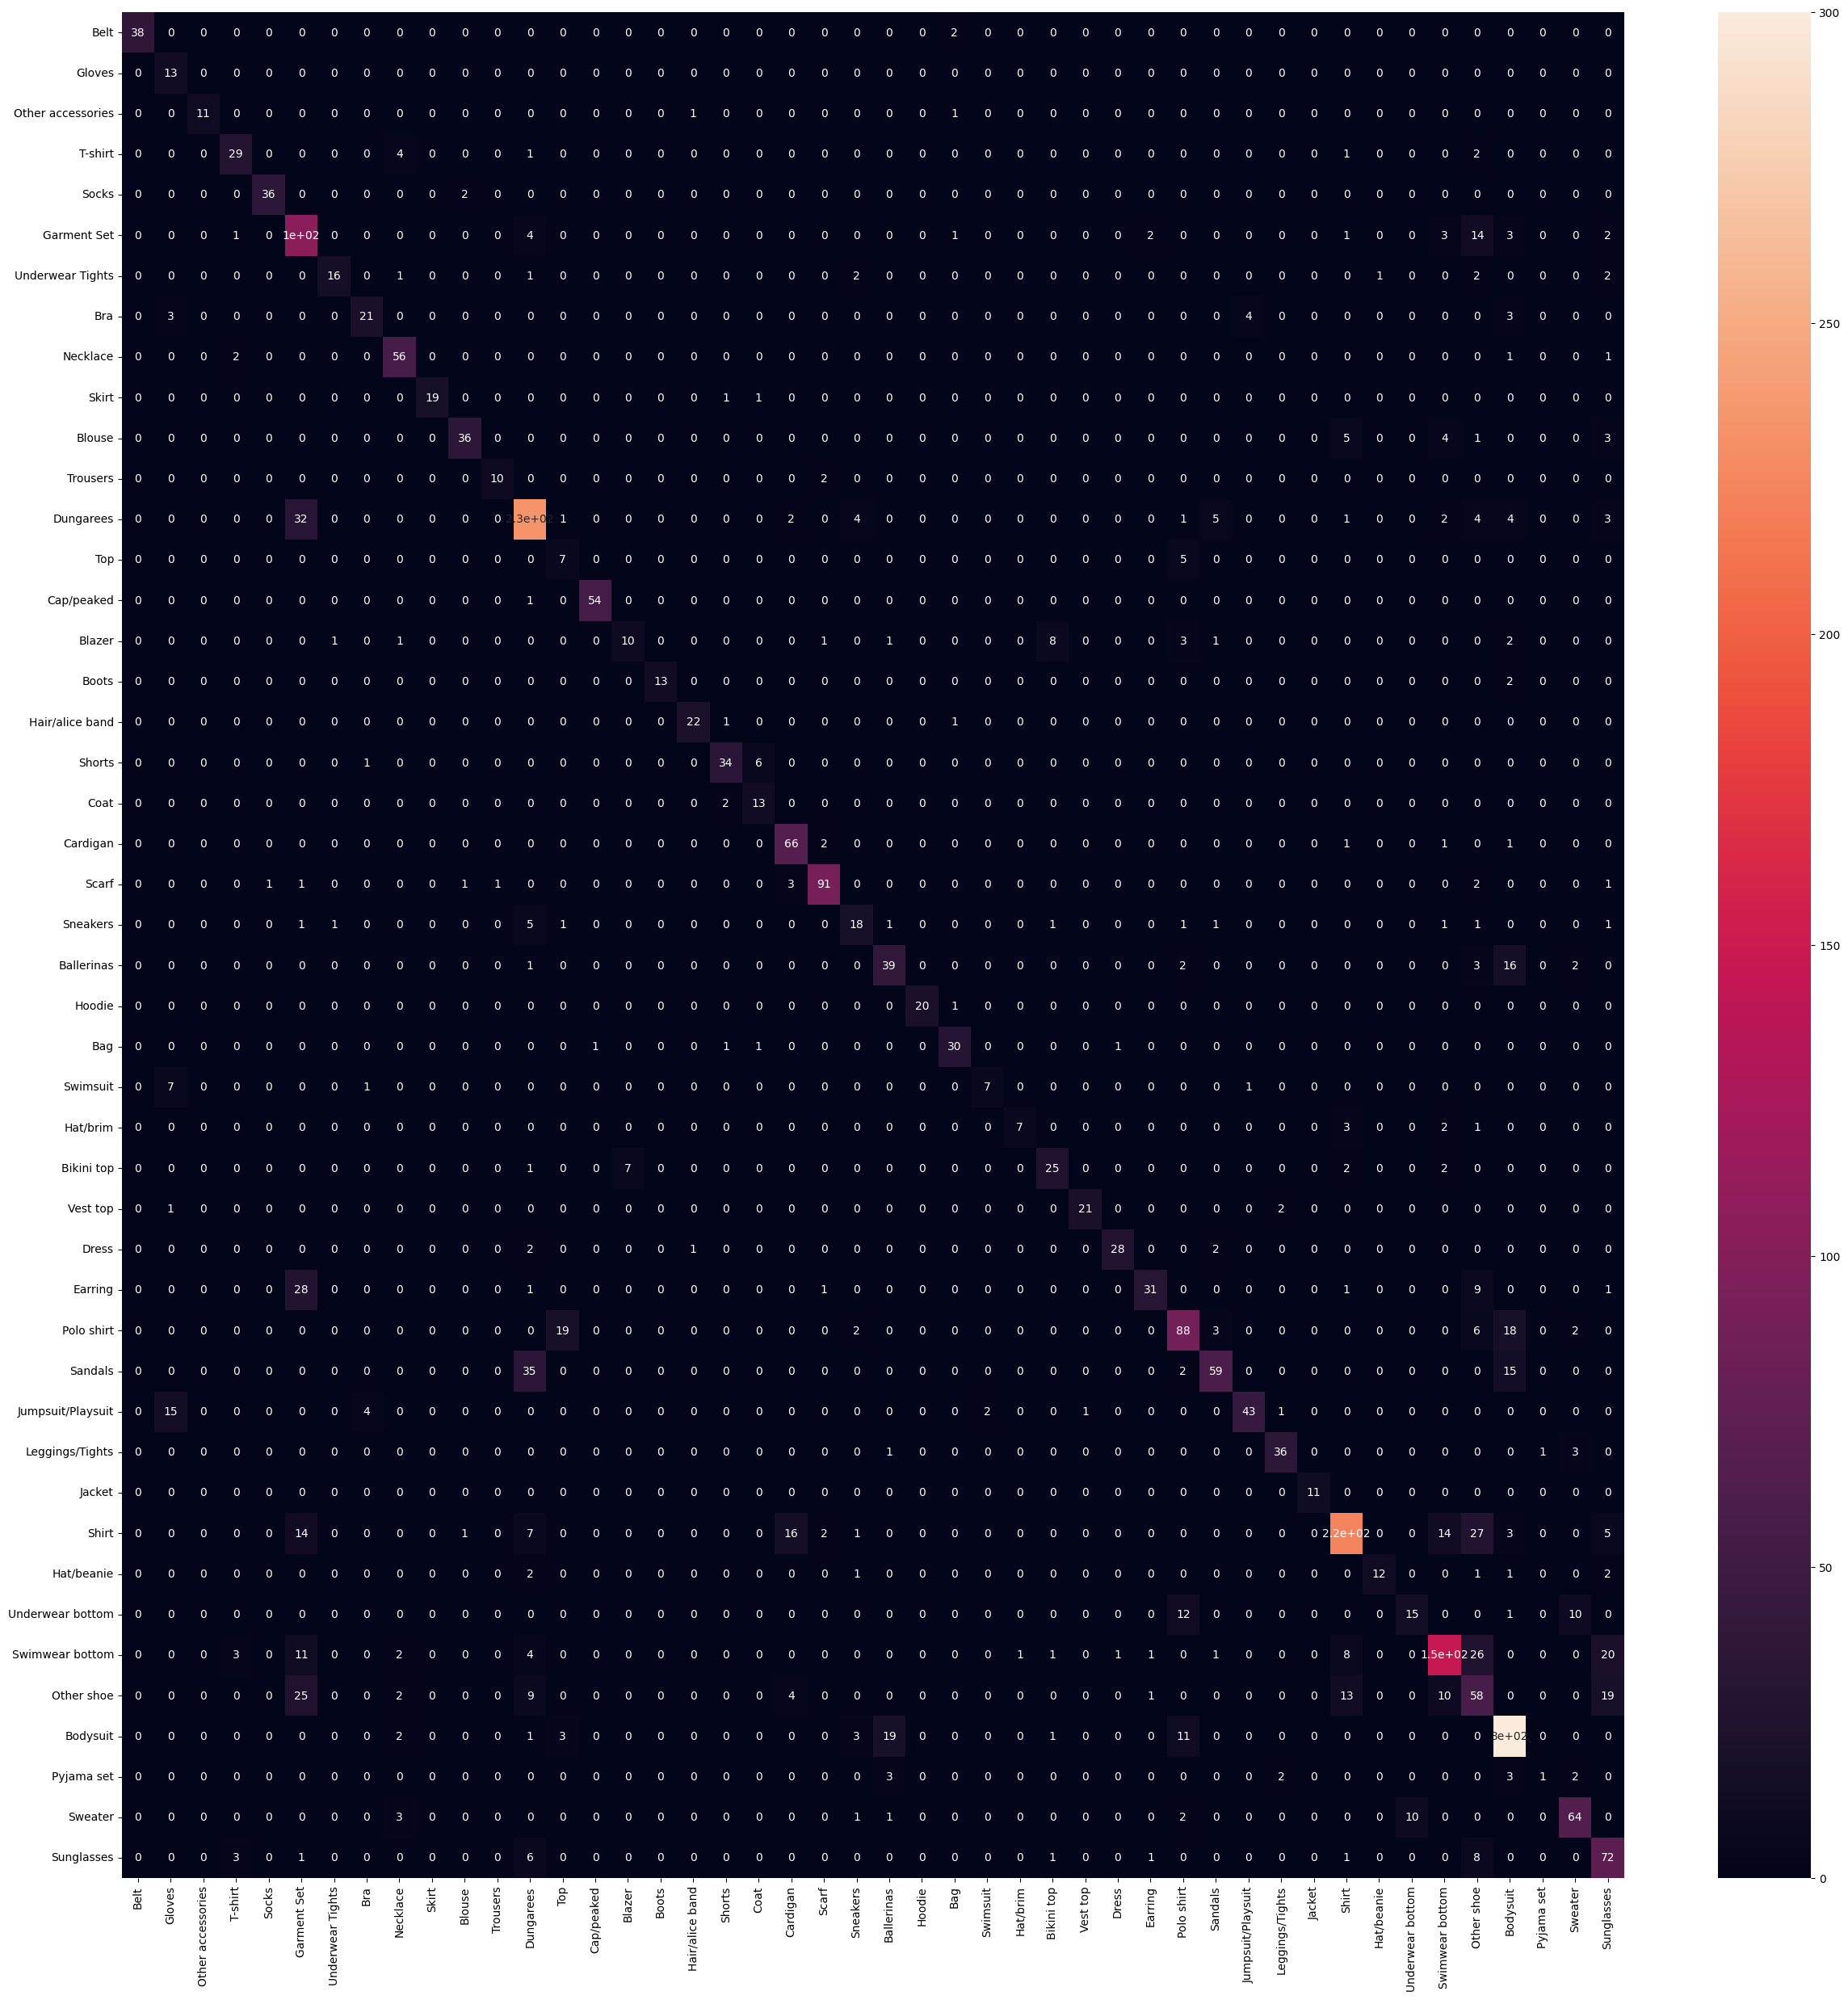

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn
labels=list(set(type_pred))
cm = confusion_matrix(type_true, type_pred)

# Create a ConfusionMatrixDisplay object and plot it
conf_matrix = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(30,30))
sn.heatmap(conf_matrix, annot=True)
plt.show()

Le modèle ne semble pas se tromper sur un type particulier, il a donc surement été entrainé sur chacun des types de produit.

In [ ]:
def search_engine(prompt):
  text_embedding = fclip.encode_text([prompt], 32)[0]

  id = np.argmax(text_embedding.dot(image_embeddings.T))
  found = subset["article_id"].iloc[id].tolist()

  image = Image.open(f"data_for_fashion_clip/{found}.jpg")

  display(image)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 35.58it/s]


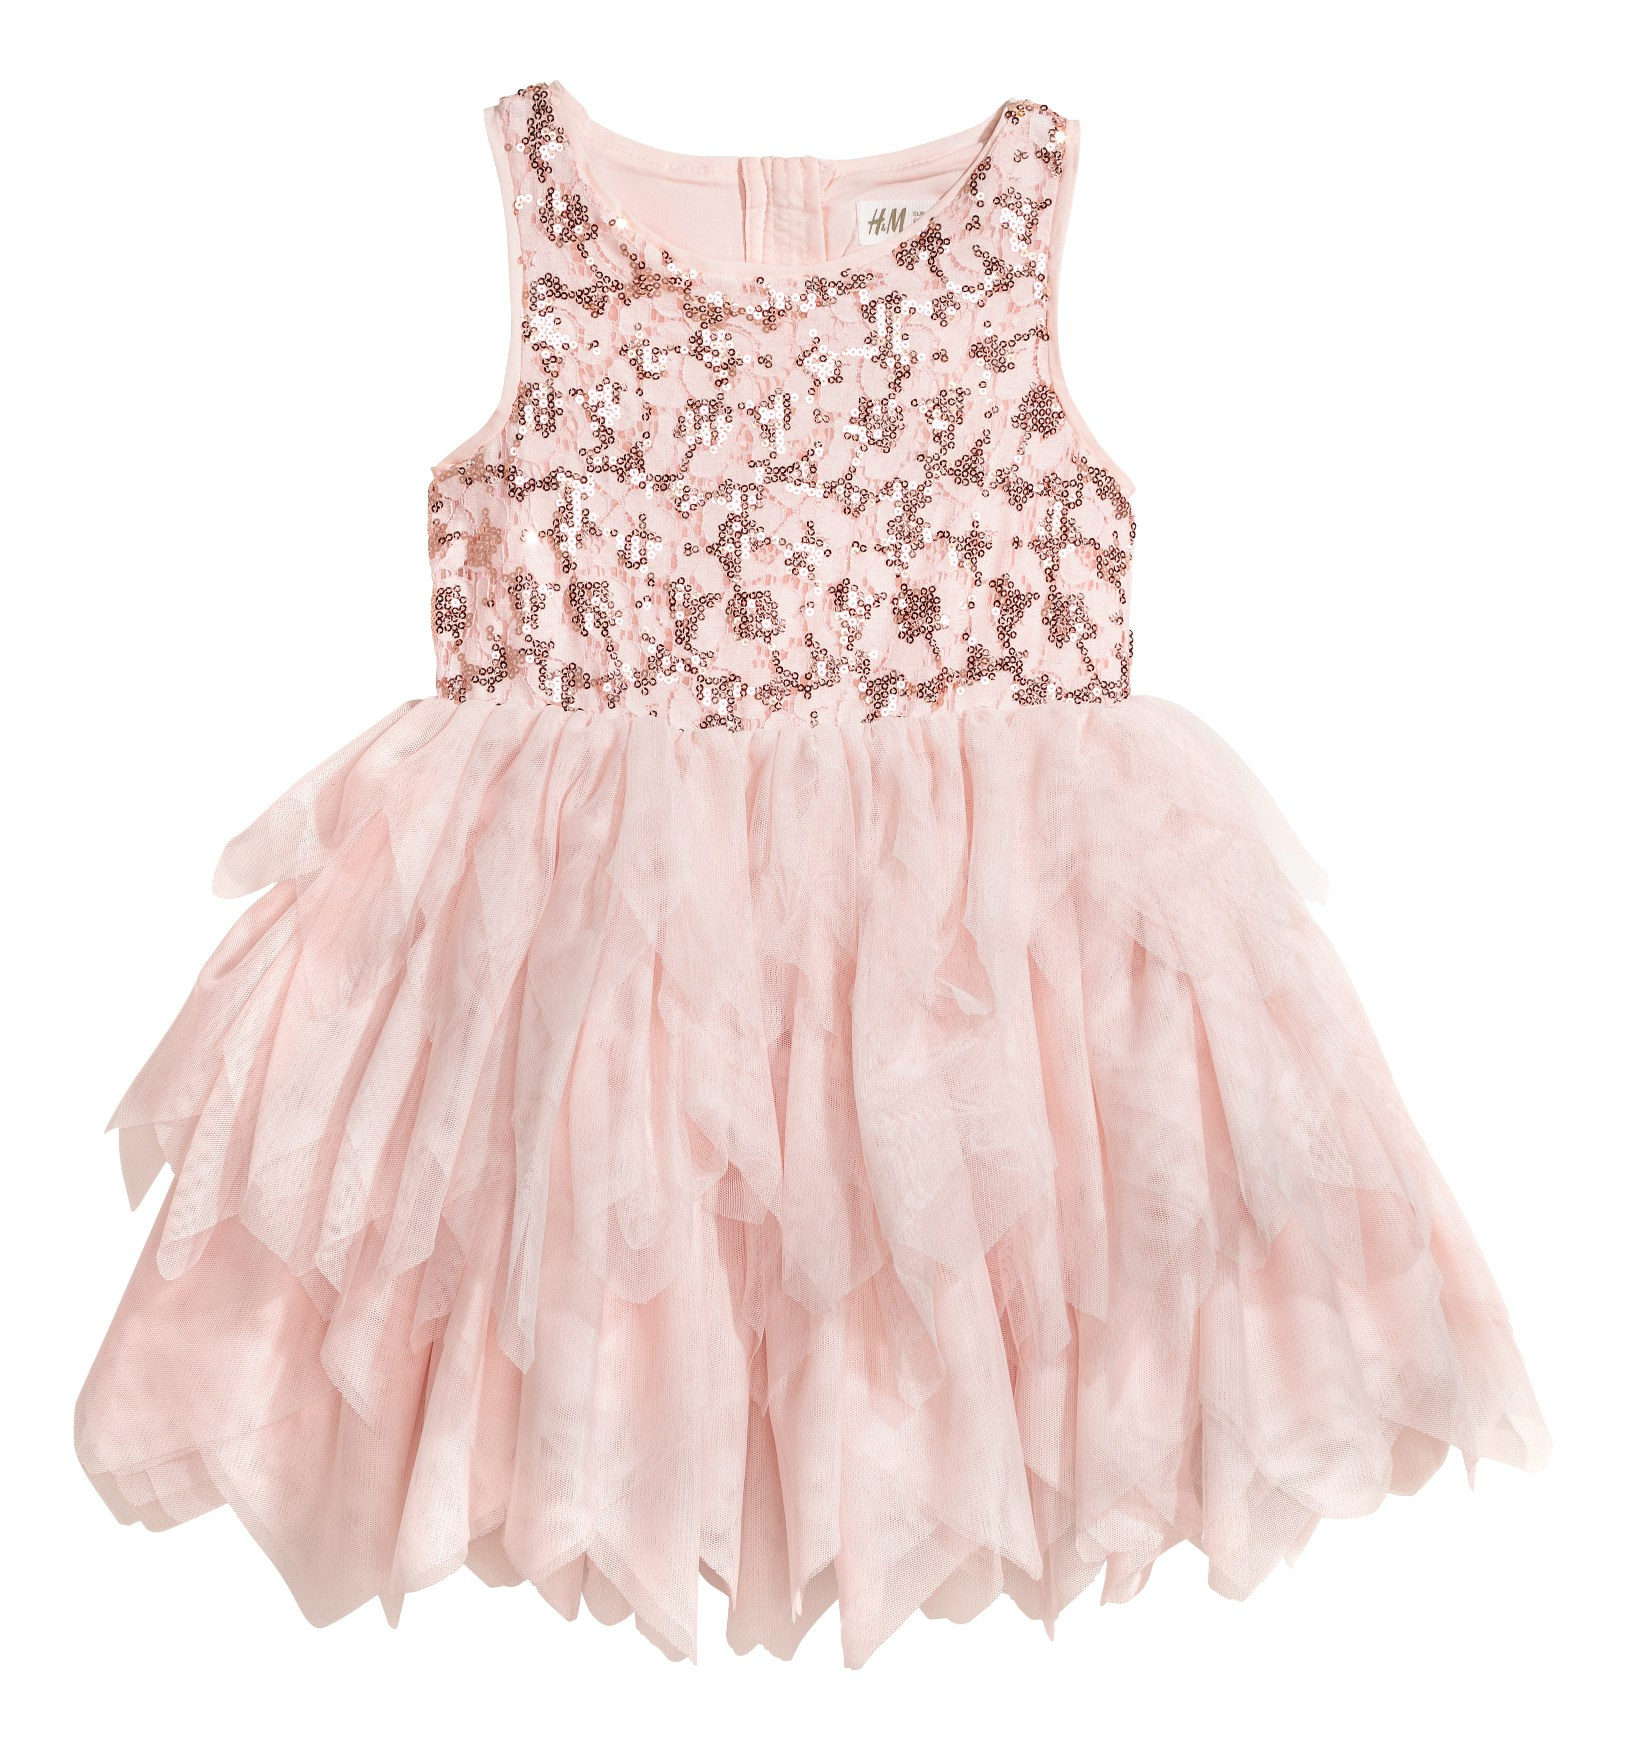

In [ ]:
search_engine("a pink dress")

Notre moteur de recherche semble bien fonctionner.

# Classification zero-shot

Construite un classsifieur d'images (prédire le label d'une image). Mesurer ses performances.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*No6ZONpQMIcfFaNMOI5oNw.gif"  width="800">



On utilisera les types de produit comme labels.

In [ ]:
labels

['Belt',
 'Gloves',
 'Other accessories',
 'T-shirt',
 'Socks',
 'Garment Set',
 'Underwear Tights',
 'Bra',
 'Necklace',
 'Skirt',
 'Blouse',
 'Trousers',
 'Dungarees',
 'Top',
 'Cap/peaked',
 'Blazer',
 'Boots',
 'Hair/alice band',
 'Shorts',
 'Coat',
 'Cardigan',
 'Scarf',
 'Sneakers',
 'Ballerinas',
 'Hoodie',
 'Bag',
 'Swimsuit',
 'Hat/brim',
 'Bikini top',
 'Vest top',
 'Dress',
 'Earring',
 'Polo shirt',
 'Sandals',
 'Jumpsuit/Playsuit',
 'Leggings/Tights',
 'Jacket',
 'Shirt',
 'Hat/beanie',
 'Underwear bottom',
 'Swimwear bottom',
 'Other shoe',
 'Bodysuit',
 'Pyjama set',
 'Sweater',
 'Sunglasses']

In [ ]:
labels_prompt = [f"a {k}" for k in labels]

label_embeddings = fclip.encode_text(labels_prompt, batch_size=32)
label_embeddings = label_embeddings/np.linalg.norm(label_embeddings, ord=2, axis=-1, keepdims=True)

Map:   0%|          | 0/46 [00:00<?, ? examples/s]

2it [00:00, 13.71it/s]


In [ ]:
from sklearn.metrics import classification_report

predicted_classes = label_embeddings.dot(image_embeddings.T)
predicted = [labels[k] for k in np.argmax(predicted_classes, axis=0)]
print(classification_report(subset["product_type_name"], predicted))

                   precision    recall  f1-score   support

              Bag       0.91      1.00      0.95        40
       Ballerinas       0.86      0.46      0.60        13
             Belt       0.92      0.92      0.92        13
       Bikini top       0.84      0.73      0.78        37
           Blazer       0.92      0.92      0.92        38
           Blouse       0.53      0.78      0.63       135
         Bodysuit       0.65      0.60      0.63        25
            Boots       0.93      0.87      0.90        31
              Bra       0.81      0.87      0.84        60
       Cap/peaked       0.95      0.90      0.93        21
         Cardigan       0.57      0.86      0.68        49
             Coat       0.20      0.92      0.33        12
            Dress       0.88      0.84      0.86       293
        Dungarees       0.35      0.67      0.46        12
          Earring       1.00      0.96      0.98        55
      Garment Set       0.75      0.11      0.19       

On obtient de très bon résultats. On a un score de 0 sur top mais c'est un mot peu précis.

Ci-dessous une démonstration du classifier.

In [ ]:
def classifier(image):
   image_embedding = fclip.encode_images([image], batch_size=32)[0]
   predicted_classes = label_embeddings.dot(image_embedding.T)
   predicted = np.argmax(predicted_classes)
   print(labels[predicted])

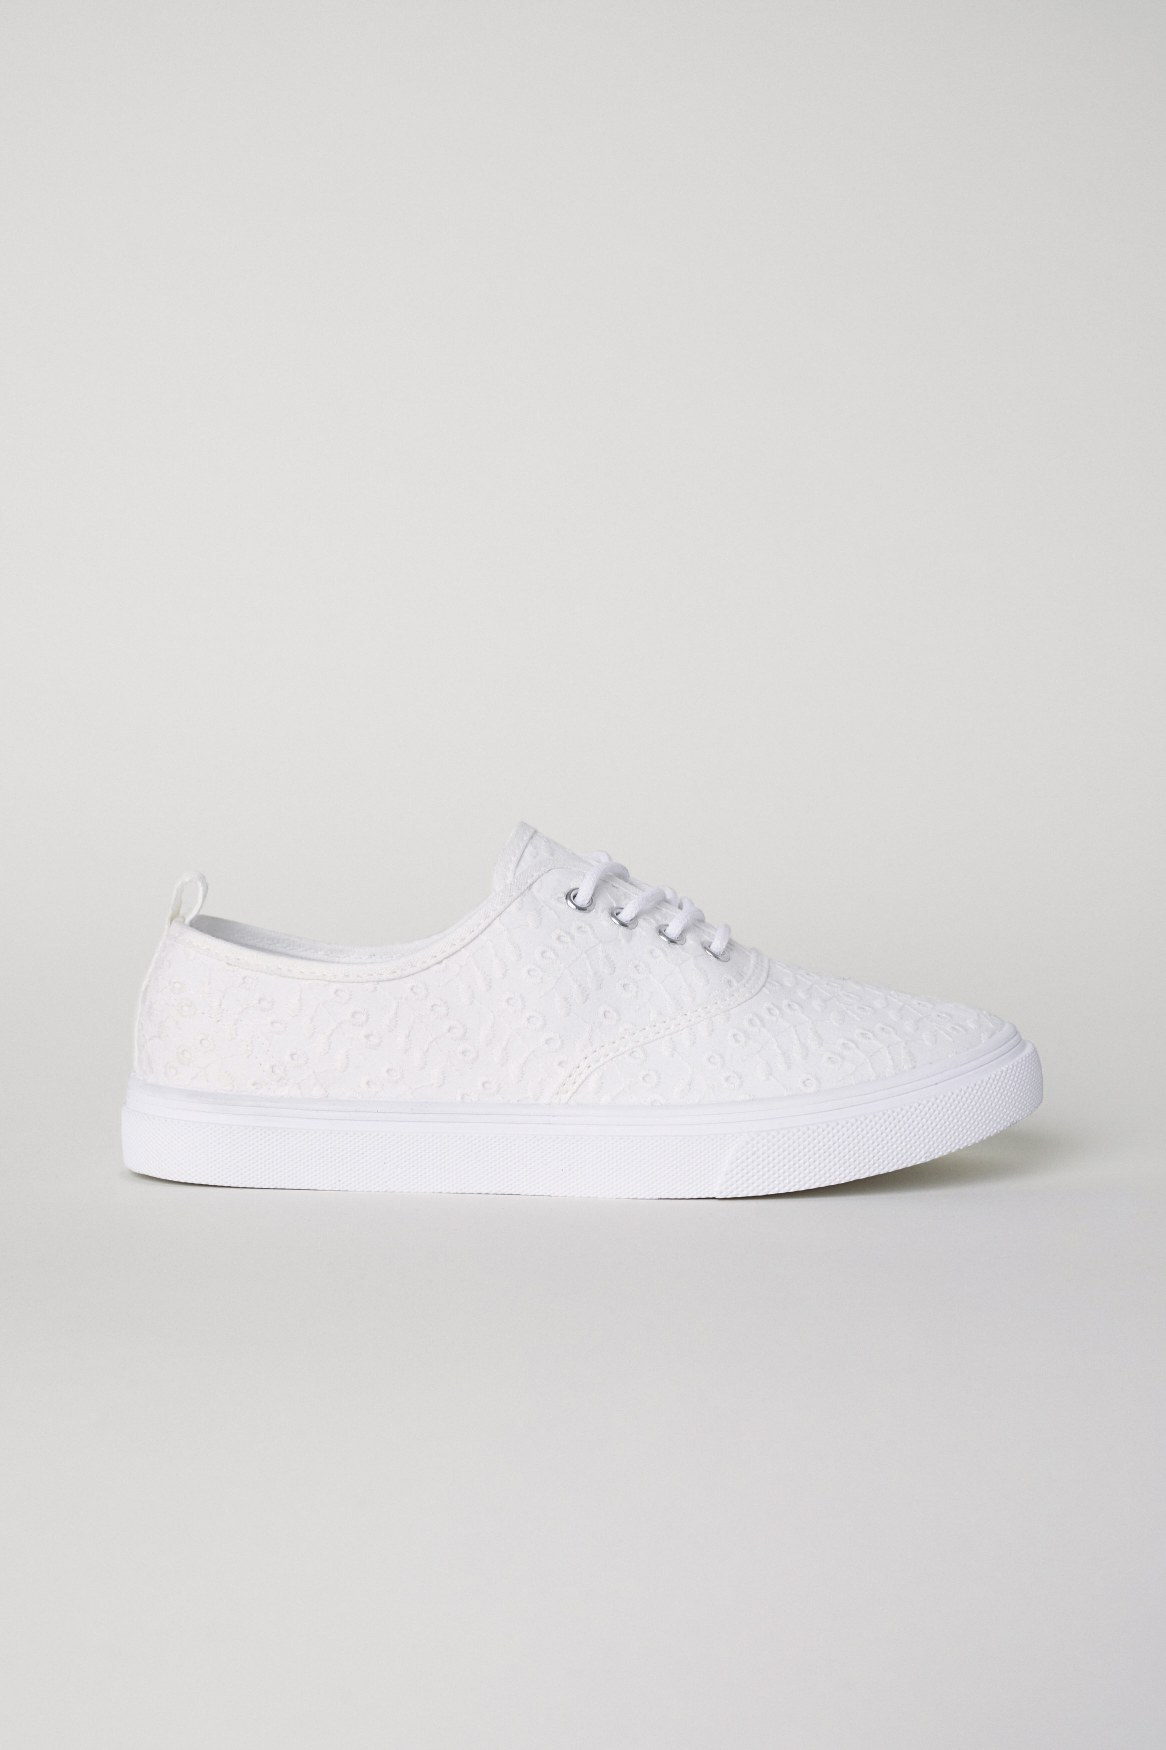

In [ ]:
img = Image.open(images[5])
img

In [ ]:
classifier(images[5])

1it [00:00, 10.99it/s]

Sneakers
